In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cma
import math
import numba
import os
from tqdm import tqdm
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami

In [2]:
#params
##data
amp, centre, sigma = (0.6969641043116005, 1.4904524578404597, 1.3102271681828053)

x_data = [0, 3, 6, 10, 20]

Aktp_data = [1.6, 2.3, 1.87, 1.8, 0.66]
Agop_data = [1.5, 2.6, 2.9, 2.1, 0.79]
Agopgw_data = [1.2, 1.5, 2.85, 2.15, 1.07]

Aktp_data_SEM = [0.17, 0.19, 0.26, 0.7, 0.27]
Agop_data_SEM = [0.22, 0.57, 0.23, 0.17, 0.42]
Agopgw_data_SEM = [0.0, 0.11, 0.21, 0.18, 0.17]

x_data2 = [-60, -30, -5, 0, 3, 6, 10, 20]

Aktp_data2 = [1, 1, 1, 1.6, 2.3, 1.87, 1.8, 0.66]
Agop_data2 = [1, 1, 1, 1.5, 2.6, 2.9, 2.1, 0.79]
Agopgw_data2 = [1, 1, 1, 1.2, 1.5, 2.85, 2.15, 1.07]

Aktp_data_SEM2 = [0.32, 0.32, 0.32, 0.17, 0.19, 0.26, 0.7, 0.27]
Agop_data_SEM2 = [0.32, 0.32, 0.32, 0.22, 0.57, 0.23, 0.17, 0.42]
Agopgw_data_SEM2 = [0.36, 0.36, 0.36, 0.0, 0.11, 0.21, 0.18, 0.17]

data = np.array([[Aktp_data], [Agop_data], [Agopgw_data]])
data_sem = np.array([[Aktp_data_SEM], [Agop_data_SEM], [Agopgw_data_SEM]])

data2 = np.array([[Aktp_data2], [Agop_data2], [Agopgw_data2]])
data_sem2 = np.array([[Aktp_data_SEM2], [Agop_data_SEM2], [Agopgw_data_SEM2]])

nmda_x = [108.77762801045833-120, 125.66705100930517-120, 147.06140279649867-120, 168.61165694983492-120, 188.7003264205789-120, 208.8734430063173-120, 224.78198028484644-120, 252.21430079412767-120, 266.70672491352275-120, 292.67421277425-120, 308.54702242720464-120, 327.3170177176539-120, 350.40031180473215-120, 369.15731523133604-120,]
nmda_y = [0.2911963882618509, 0.5530474040632054, 0.6839729119638827, 0.7065462753950338, 0.7449209932279908, 0.7246049661399547, 0.6681715575620766, 0.6027088036117381, 0.5304740406320541, 0.4830699774266365, 0.4514672686230248, 0.4063205417607221, 0.3634311512415347, 0.3273137697516928,]
nmda_sem = [0.3702031602708802, 0.6817155756207673, 0.8600451467268622, 0.8893905191873588, 0.9638826185101579, 0.9480812641083518, 0.8781038374717831, 0.8239277652370203, 0.7223476297968396, 0.6681715575620766, 0.6094808126410833, 0.5643340857787809, 0.5079006772009027, 0.46275395033860045]
nmda_sem = np.array(nmda_sem) - np.array(nmda_y)
nmda_x = np.array(nmda_x) / 60

nmda_y = np.array(nmda_y)

##others
dt = 0.01
minutes = 20
numtimesteps = minutes/dt #100

#rate constants
k1 = 1 #0.4513
k_1 = 1 #0.1
k2 = 1 #0.1332
k_2 = 1 #6.65
k3 = 1 #0.3925
k_3 = 1 #0.2
k4 = 1 #0.017 #* 10
k_4 = 1 #0.017 #* 0
k5 = 1 #0.35 #* 0
k_5 = 1 #0.017 #* 0

Akt_init = 1 #0.686
Aktpb_init = 1 #0
Aktpf_init = 1 #0
Ago_init = 1 #78
Agop_init = 1 #0
Gw_init = 1 #0.71
Agopgw_init = 1 #0

rates = [k1, k_1, k2, k_2, k3, k_3]
inits = [Akt_init, Aktpb_init,  Ago_init, Agop_init, Gw_init, Agopgw_init]

theta = np.array(rates + inits)

beg = 0
beg2 = -10

In [3]:
#gaussian function
def gauss(x, amp, centre, sigma):
    return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 

In [54]:
#first simple model function

#@numba.jit()
def model1(theta):
    
    def gauss(x, amp, centre, sigma):
        return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 
    
    k1, k_1, k2, k_2, k3, k_3, Akt0, Aktp0, Ago0, Agop0, Gw0, Agopgw0 = np.exp(np.array(list(theta), dtype = np.float64))
    
    Akt = np.zeros(int((minutes - beg)/dt))
    Aktp = np.zeros(int((minutes - beg)/dt))
    Ago = np.zeros(int((minutes - beg)/dt))
    Agop = np.zeros(int((minutes - beg)/dt))
    Gw = np.zeros(int((minutes - beg)/dt))
    Agopgw = np.zeros(int((minutes - beg)/dt))
    time = np.linspace(int(beg), int(minutes), int((minutes-beg)/dt))
    
    NMDA = gauss(time, amp, centre, sigma)
    
    Akt[0] = Akt0
    Aktp[0] = Aktp0
    Ago[0] = Ago0
    Agop[0] = Agop0
    Gw[0] = Gw0
    Agopgw[0] = Agopgw0
    
    for i in range(1, int((minutes-beg)/dt)):
        Akt[i] = Akt[i-1] + dt*(Aktp[i-1]*k_1 - Akt[i-1]*k1*NMDA[i])
        Aktp[i] = Aktp[i-1] + dt*(Akt[i-1]*k1*NMDA[i] - Aktp[i-1]*k_1)
        Ago[i] = Ago[i-1] + dt*(Agop[i-1]*k_2 - Aktp[i-1]*Ago[i-1]*k2)
        Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
        Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
        Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
        
    return Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time

In [73]:
#first simple model function fc calculation
def foldChange1(theta):
    Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time = model1(theta)
    
    Aktp_fold = np.zeros(len(Akt))
    Agop_fold = np.zeros(len(Akt))
    Agopgw_fold = np.zeros(len(Akt))
    
    for i in range(len(Akt)):
        if math.isinf(Aktp[i]):
            if Aktp[i] > 0:
                Aktp[i] = Aktp[0] + Akt[0]
            elif Aktp[i] < 0:
                Aktp[i] = 0
        if math.isinf(Agop[i]):
            if Agop[i] > 0:
                Agop[i] = Agop[0] + Ago[0] + Agopgw[0]
            elif Agop[i] < 0:
                Agop[i] = 0
        if math.isinf(Agopgw[i]):
            if Agopgw[i] > 0:
                Agopgw[i] = Gw[0] + Agopgw[0]
            elif Agopgw[i] < 0:
                Agopgw[i] = 0

        if math.isnan(Aktp[i]):
            if Aktp[i-1] > 1:
                Aktp[i] = Aktp[0] + Akt[0]
            elif Aktp[i-1] < 1:
                Aktp[i] = 0
        if math.isnan(Agop[i]):
            if Agop[i-1] > 1:
                Agop[i] = Agop[0] + Ago[0] + Agopgw[0]
            elif Agop[i-1] < 1:
                Agop[i] = 0
        if math.isnan(Agopgw[i]):
            if Agopgw[i-1] > 1:
                Agopgw[i] = Gw[0] + Agopgw[0]
            elif Agopgw[i-1] < 1:
                Agopgw[i] = 0
                
        Aktp_fold[i] = Aktp[i] / ( Aktp[0] )#+ Akt[0]) / akcont
        Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
        Agopgw_fold[i] = Agopgw[i] / ( Agopgw[0] )#+ Gw[0]) / gwcont
            
    return Aktp_fold, Agop_fold, Agopgw_fold, time 

In [74]:
def error1(theta):
    Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta)
    
    aktp_model = list(np.interp(x_data, time, Aktp_fold))
    agop_model = list(np.interp(x_data, time, Agop_fold))
    agopgw_model = list(np.interp(x_data, time, Agopgw_fold))
    
    model = np.array([[aktp_model], [agop_model], [agopgw_model]])
    
    return np.sum((data - model)**2)

In [75]:
def bounds(theta, fold):
    """
    Function to calculate bounds for sensitivity analysis
    """
    bounds = []
    for i in theta:
        bnds = [i**(-fold), i**fold]
        if bnds[0] > bnds[1]:
            bnds = [bnds[1], bnds[0]]
        bounds.append(bnds)
    return bounds

In [76]:
def bounds2(theta, percent):
    """
    Function to calculate bounds for sensitivity analysis
    """
    bounds = []
    for i in theta:
        bnds = [i*percent, i*(1+(1-percent))]
        if bnds[0] > bnds[1]:
            bnds = [bnds[1], bnds[0]]
        bounds.append(bnds)
    return bounds

In [77]:
def model_fit(theta):
    """
    Function to evaluate the impact of parameter value on variance of model fit for individual data segment
    """
    Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta)

    aktp_model = np.interp(x_data, time, Aktp_fold)
    agop_model = np.interp(x_data, time, Agop_fold)
    agopgw_model = np.interp(x_data, time, Agopgw_fold)

    return [np.sum((np.array(Aktp_data)-aktp_model)**2), np.sum((np.array(Agop_data)-agop_model)**2), np.sum((np.array(Agopgw_data)-agopgw_model)**2)]

In [78]:
def calc_area(theta):
    """
    Function to evaluate impact of parameter value on variance for investigated protein quantity
    """

    Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta)

    return [scipy.integrate.simps(Aktp_fold, time), scipy.integrate.simps(Agop_fold, time), scipy.integrate.simps(Agopgw_fold, time)]

In [79]:
opt_theta = [-2.1891086172494694, -2.4433488194546342, -24.246747947385302, 0.3097092957302445, -5.566253607295039, -0.529244446408704, -7.789006960185361, -9.934601074801321, 9.036872136090096, -25.710634963063058, -20.33791222058062, -51.037103097041836]

In [107]:
test_dic = {
    'num_vars': len(opt_theta),
    'names': ['$k_1$', '$k_{-1}$', '$k_2$', '$k_{-2}$', '$k_3$', '$k_{-3}$', '$Akt_0$', '$pAkt_0$', '$Ago2_0$', '$pAgo2_0$', '$pAgo2:GW182_0$', '$GW182_0$'],
    'bounds': bounds2(opt_theta, .01)}

In [82]:
param_vals = saltelli.sample(test_dic, 2**6)

C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2331533585.py:1: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_vals = saltelli.sample(test_dic, 2**6)


In [83]:
param_vals.shape

(1664, 12)

In [84]:
## Analyse global effects with no regard to effects over time
Y1a = np.zeros([param_vals.shape[0]])
Y2a = np.zeros([param_vals.shape[0]])
Y3a = np.zeros([param_vals.shape[0]])

In [86]:
### Evaluate effects on model fit
for i, X in tqdm(enumerate(param_vals)):
    Y1a[i] = model_fit(X)[0]
    Y2a[i] = model_fit(X)[1]
    Y3a[i] = model_fit(X)[2]

732it [00:22, 32.59it/s]C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:32: RuntimeWarning: overflow encountered in scalar multiply
  Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:33: RuntimeWarning: overflow encountered in scalar multiply
  Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:34: RuntimeWarning: overflow encountered in scalar multiply
  Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:33: RuntimeWarning: invalid value encountered in scalar sub

In [87]:
### Evaluate effects on protein 
Y1b = np.zeros([param_vals.shape[0]])
Y2b = np.zeros([param_vals.shape[0]])
Y3b = np.zeros([param_vals.shape[0]])

for i, X in tqdm(enumerate(param_vals)):
    Y1b[i] = calc_area(X)[0]
    Y2b[i] = calc_area(X)[1]
    Y3b[i] = calc_area(X)[2]

0it [00:00, ?it/s]C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\587394710.py:8: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  return [scipy.integrate.simps(Aktp_fold, time), scipy.integrate.simps(Agop_fold, time), scipy.integrate.simps(Agopgw_fold, time)]
732it [00:22, 32.51it/s]C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:32: RuntimeWarning: overflow encountered in scalar multiply
  Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:33: RuntimeWarning: overflow encountered in scalar multiply
  Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:34: RuntimeWarning: overflow encountered in scalar multiply
  Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
C:\Users\So

In [88]:
foldChange1(param_vals[733])

C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:32: RuntimeWarning: overflow encountered in scalar multiply
  Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:33: RuntimeWarning: overflow encountered in scalar multiply
  Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:34: RuntimeWarning: overflow encountered in scalar multiply
  Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:33: RuntimeWarning: invalid value encountered in scalar subtract
  Gw[i] = Gw[i-1] 

(array([1.        , 0.99981555, 0.99963118, ..., 0.69520164, 0.69507341,
        0.6949452 ]),
 array([1.00000000e+00, 8.95309868e+08, 1.77280206e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.00000000e+00, 2.27813319e+24, 2.03963513e+33, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([0.00000000e+00, 1.00050025e-02, 2.00100050e-02, ...,
        1.99799900e+01, 1.99899950e+01, 2.00000000e+01]))

In [89]:
np.exp(param_vals[733])

array([4.80420810e-02, 1.84449169e-02, 2.54700196e-01, 1.77394194e+00,
       1.17146534e-02, 9.70588496e-01, 3.77176002e-06, 7.76450900e-01,
       3.42908534e+06, 7.57439936e-06, 1.34779989e-05, 5.24957263e-39])

In [90]:
### Run analyses
S1a = sobol.analyze(test_dic, Y1a)
S2a = sobol.analyze(test_dic, Y2a)
S3a = sobol.analyze(test_dic, Y3a)

S1b = sobol.analyze(test_dic, Y1b)
S2b = sobol.analyze(test_dic, Y2b)
S3b = sobol.analyze(test_dic, Y3b)

C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
C:\Users\Sofia\anaconda3\envs\numpy1\lib\site-packages\numpy\core\_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\SALib\analyze\sobol.py:216: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\SALib\analyze\sobol.py:229: UserWarning: Constant values encountered, indicating model evaluations (or subset of evaluations) produced identical values.
  warn(CONST_RESULT_MSG)
C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\SALib\analyze\sobol.py:239

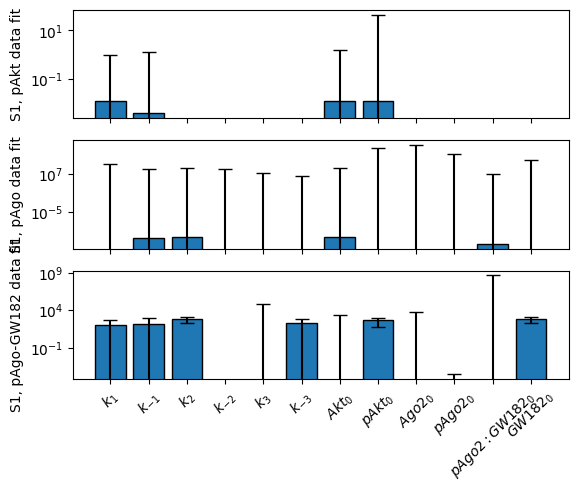

In [128]:
## plot effects on fit
fig, ax = plt.subplots(3, sharex = True)
x = np.linspace(1, test_dic['num_vars'], test_dic['num_vars'])
w = 0.8
ax[0].bar(x,
          S1a['S1'],
          yerr = S1a['S1_conf'],
          color = 'C0',
          edgecolor = 'black',
          ecolor = 'black',
          capsize = 5,
          width = w)
ax[0].set_ylabel('S1, pAkt data fit')
plt.xticks(x, test_dic['names'], rotation = 45)
ax[0].set_yscale('log')
#ax[0].set_xticklabels(test_dic['names'], rotation = 45)

ax[1].bar(x,
          S2a['S1'],
          yerr = S2a['S1_conf'],
          color = 'C0',
          edgecolor = 'black',
          ecolor = 'black',
          capsize = 5,
          width = w)
ax[1].set_ylabel('S1, pAgo data fit')
ax[1].set_yscale('log')

ax[2].bar(x,
          S3a['S1'],
          yerr = S3a['S1_conf'],
          color = 'C0',
          edgecolor = 'black',
          ecolor = 'black',
          capsize = 5,
          width = w)
ax[2].set_ylabel('S1, pAgo-GW182 data fit')
ax[2].set_yscale('log')

plt.savefig(r'./plots/S1_model-fit_no-time.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

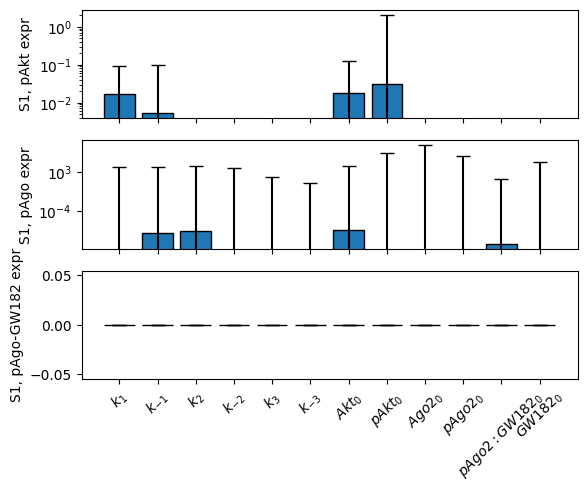

In [129]:
## plot effects on protein exp
fig, ax = plt.subplots(3, sharex = True)
x = np.linspace(1, test_dic['num_vars'], test_dic['num_vars'])
w = 0.8
ax[0].bar(x,
          S1b['S1'],
          yerr = S1b['S1_conf'],
          color = 'C0',
          edgecolor = 'black',
          ecolor = 'black',
          capsize = 5,
          width = w)
ax[0].set_ylabel('S1, pAkt expr')
plt.xticks(x, test_dic['names'], rotation = 45)
#ax[0].set_xticklabels(test_dic['names'], rotation = 45)
ax[0].set_yscale('log')

ax[1].bar(x,
          S2b['S1'],
          yerr = S2b['S1_conf'],
          color = 'C0',
          edgecolor = 'black',
          ecolor = 'black',
          capsize = 5,
          width = w)
ax[1].set_ylabel('S1, pAgo expr')
ax[1].set_yscale('log')

ax[2].bar(x,
          S3b['S1'],
          yerr = S3b['S1_conf'],
          color = 'C0',
          edgecolor = 'black',
          ecolor = 'black',
          capsize = 5,
          width = w)
ax[2].set_ylabel('S1, pAgo-GW182 expr')
#ax[2].set_yscale('log')

plt.savefig(r'./plots/S1_protein-expr_no-time.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [130]:
S1a['S2']

array([[            nan, -1.23215791e-02, -1.23215779e-02,
        -1.23215779e-02, -1.23215779e-02, -1.23215779e-02,
        -1.23215602e-02, -1.21586449e-02, -1.23215779e-02,
        -1.23215779e-02, -1.23215779e-02, -1.23215779e-02],
       [            nan,             nan, -4.92123157e-03,
        -4.92123157e-03, -4.92123157e-03, -4.92123157e-03,
        -4.92123264e-03, -4.89020597e-03, -4.92123157e-03,
        -4.92123157e-03, -4.92123157e-03, -4.92123157e-03],
       [            nan,             nan,             nan,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.46944695e-18,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [            nan,             nan,             nan,
                    nan,  0.00000000e+00,  0.00000000e+00,
         3.46944695e-18,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [            nan,             nan,           

In [138]:
import pandas as pd
import seaborn as sns

In [141]:
S1a_S2 = pd.DataFrame(S1a['S2'], columns = test_dic['names'], index = test_dic['names'])
S2a_S2 = pd.DataFrame(S2a['S2'], columns = test_dic['names'], index = test_dic['names'])
S3a_S2 = pd.DataFrame(S3a['S2'], columns = test_dic['names'], index = test_dic['names'])

S1b_S2 = pd.DataFrame(S1b['S2'], columns = test_dic['names'], index = test_dic['names'])
S2b_S2 = pd.DataFrame(S2b['S2'], columns = test_dic['names'], index = test_dic['names'])
S3b_S2 = pd.DataFrame(S3b['S2'], columns = test_dic['names'], index = test_dic['names'])

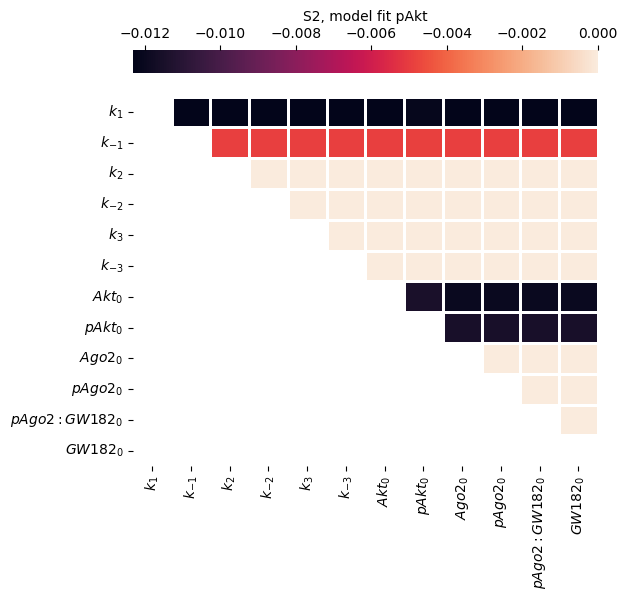

In [160]:
fig, ax = plt.subplots(figsize = (6,6))

ax = sns.heatmap(S1a_S2,
                linewidth = 1,
                cbar_kws = {'location': 'top',
                            'label': 'S2, model fit pAkt'})

plt.savefig('S2_model-fit_pAkt.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

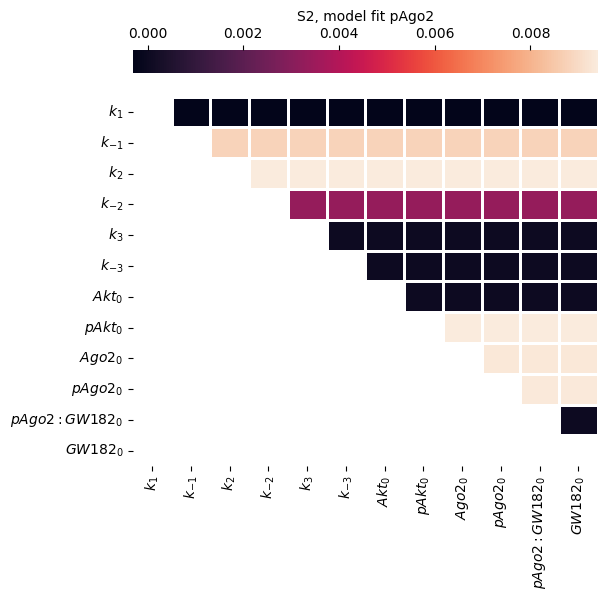

In [161]:
fig, ax = plt.subplots(figsize = (6,6))

ax = sns.heatmap(S2a_S2,
                linewidth = 1,
                cbar_kws = {'location': 'top',
                            'label': 'S2, model fit pAgo2'})

plt.savefig('S2_model-fit_pAgo.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

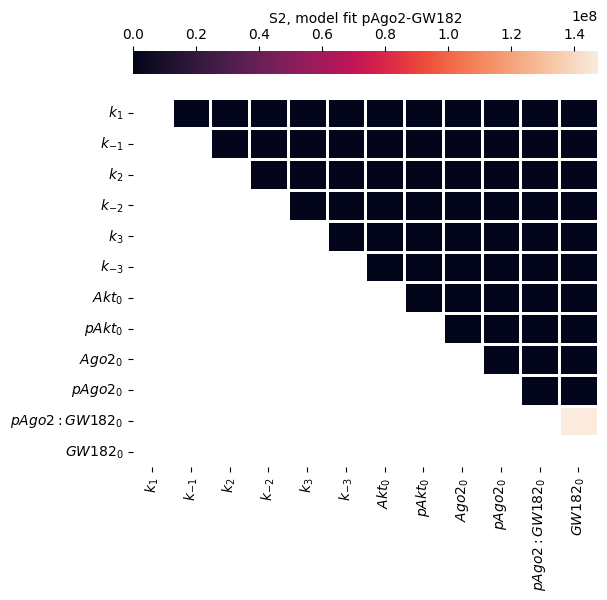

In [162]:
fig, ax = plt.subplots(figsize = (6,6))

ax = sns.heatmap(S3a_S2,
                linewidth = 1,
                cbar_kws = {'location': 'top',
                            'label': 'S2, model fit pAgo2-GW182'})

plt.savefig('S2_model-fit_pAgo2-GW182.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

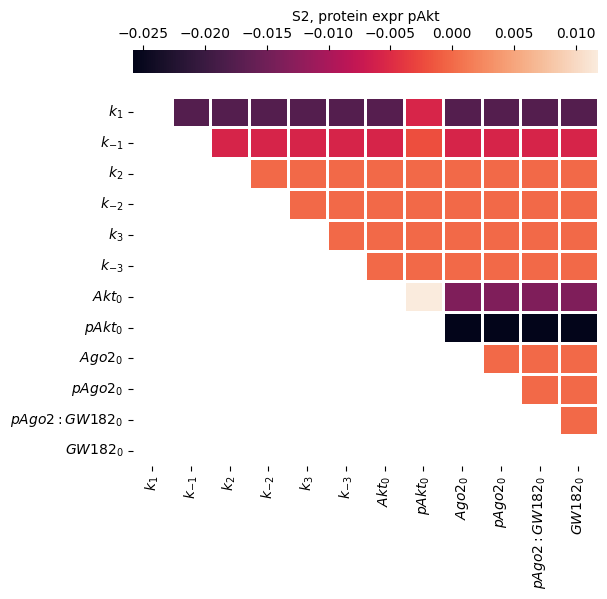

In [163]:
fig, ax = plt.subplots(figsize = (6,6))

ax = sns.heatmap(S1b_S2,
                linewidth = 1,
                cbar_kws = {'location': 'top',
                            'label': 'S2, protein expr pAkt'})

plt.savefig('S2_protein_pAkt.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

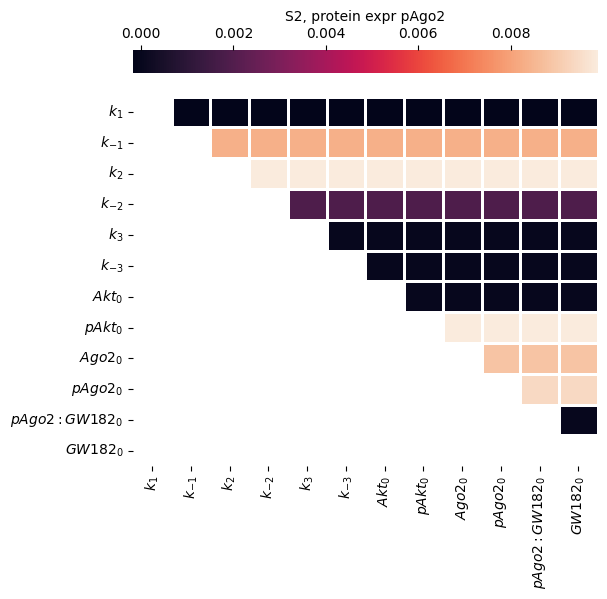

In [164]:
fig, ax = plt.subplots(figsize = (6,6))

ax = sns.heatmap(S2b_S2,
                linewidth = 1,
                cbar_kws = {'location': 'top',
                            'label': 'S2, protein expr pAgo2'})

plt.savefig('S2_protein_pAgo.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

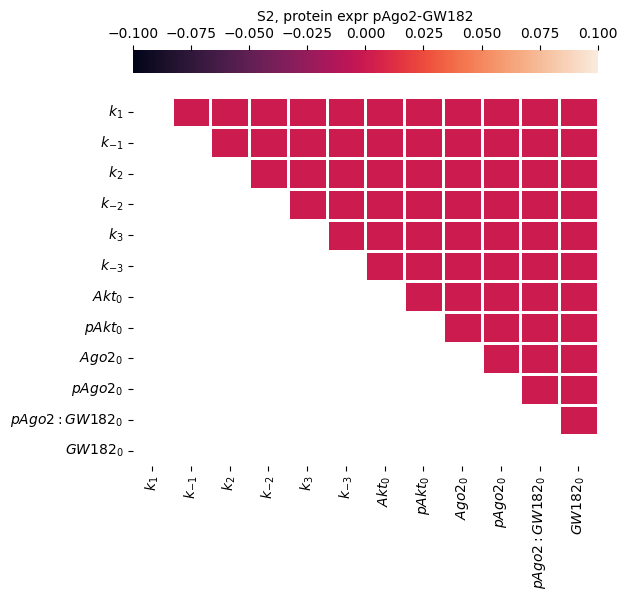

In [165]:
fig, ax = plt.subplots(figsize = (6,6))

ax = sns.heatmap(S3b_S2,
                linewidth = 1,
                cbar_kws = {'location': 'top',
                            'label': 'S2, protein expr pAgo2-GW182'})

plt.savefig('S2_protein_pAgo2-GW182.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [166]:
## evaluate total fit, no time
Yt = np.zeros([param_vals.shape[0]])

for i, X in tqdm(enumerate(param_vals)):
    Yt[i] = error1(X)

728it [00:07, 99.21it/s] C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:32: RuntimeWarning: overflow encountered in scalar multiply
  Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:33: RuntimeWarning: overflow encountered in scalar multiply
  Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:34: RuntimeWarning: overflow encountered in scalar multiply
  Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
C:\Users\Sofia\AppData\Local\Temp\ipykernel_48020\2448341145.py:33: RuntimeWarning: invalid value encountered in scalar su

In [167]:
St = sobol.analyze(test_dic, Yt)

C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


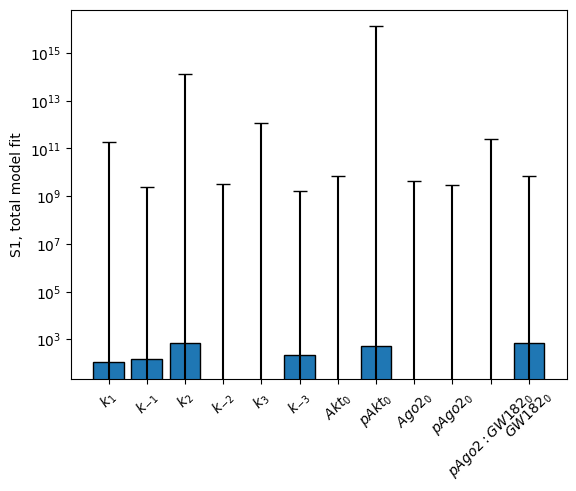

In [174]:
fig, ax = plt.subplots()
ax.bar(x,
          St['S1'],
          yerr = St['S1_conf'],
          color = 'C0',
          edgecolor = 'black',
          ecolor = 'black',
          capsize = 5,
          width = w)
ax.set_ylabel('S1, total model fit')
plt.xticks(x, test_dic['names'], rotation = 45)
ax.set_yscale('log')

plt.savefig(r'./plots/S1_full-model-fit_no-time.svg', dpi = 600, bbox_inches = 'tight')
plt.show()

In [175]:
St_S2 = pd.DataFrame(St['S2'], columns = test_dic['names'], index = test_dic['names'])

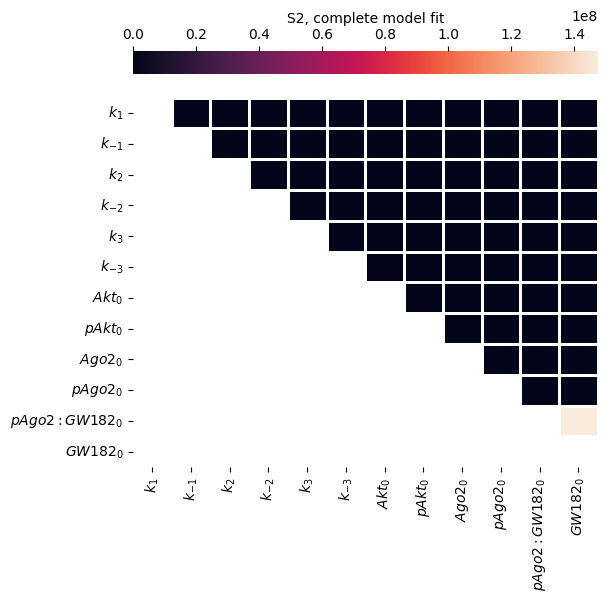

In [176]:
fig, ax = plt.subplots(figsize = (6,6))

ax = sns.heatmap(St_S2,
                linewidth = 1,
                cbar_kws = {'location': 'top',
                            'label': 'S2, complete model fit'})

plt.savefig('S2_full-model-fit_no-time.svg', dpi = 600, bbox_inches = 'tight')
plt.show()